In [1]:
!pip install -U ucimlrepo scikit-learn pandas matplotlib seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 38.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
wholesale = fetch_ucirepo(name="Wholesale customers")
X = wholesale.data.features
df = X.copy()


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class IdentityTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X

def get_preprocessing_methods():
    return {
        'No Processing': Pipeline([('identity', IdentityTransformer())]),
        'Normalization': Pipeline([('scale', StandardScaler())]),
        'Transform': Pipeline([('log', FunctionTransformer(np.log1p))]),
        'PCA': Pipeline([('pca', PCA(n_components=2))]),
        'T+N': Pipeline([('log', FunctionTransformer(np.log1p)), ('scale', StandardScaler())]),
        'T+N+PCA': Pipeline([('log', FunctionTransformer(np.log1p)),
                             ('scale', StandardScaler()),
                             ('pca', PCA(n_components=2))])
    }



In [4]:
def apply_clustering(X, method, n_clusters=None):
    if method == 'kmeans':
        return KMeans(n_clusters=n_clusters, random_state=42).fit_predict(X)
    elif method == 'hierarchical':
        return AgglomerativeClustering(n_clusters=n_clusters).fit_predict(X)
    elif method == 'meanshift':
        bandwidth = estimate_bandwidth(X, quantile=0.2)
        return MeanShift(bandwidth=bandwidth).fit_predict(X)


In [5]:
def evaluate_clustering(X, labels):
    if len(np.unique(labels)) < 2:
        return {'Silhouette': np.nan, 'Calinski': np.nan, 'Davies': np.nan}
    return {
        'Silhouette': silhouette_score(X, labels),
        'Calinski': calinski_harabasz_score(X, labels),
        'Davies': davies_bouldin_score(X, labels)
    }


In [6]:
preprocessing_methods = get_preprocessing_methods()
cluster_counts = [3, 4, 5]
algorithms = ['kmeans', 'hierarchical', 'meanshift']
results = []

for prep_name, prep_pipe in preprocessing_methods.items():
    X_prep = prep_pipe.fit_transform(X)

    for algo in algorithms:
        for k in cluster_counts:
            if algo == 'meanshift':
                if k != 3: continue  # Only run once for mean shift
                labels = apply_clustering(X_prep, algo)
            else:
                labels = apply_clustering(X_prep, algo, n_clusters=k)

            scores = evaluate_clustering(X_prep, labels)
            results.append({
                'Preprocessing': prep_name,
                'Algorithm': algo,
                'Clusters': k,
                **scores
            })


In [7]:
results_df = pd.DataFrame(results)
results_df[['Silhouette', 'Calinski', 'Davies']] = results_df[['Silhouette', 'Calinski', 'Davies']].round(4)
print(results_df)


    Preprocessing     Algorithm  Clusters  Silhouette  Calinski  Davies
0   No Processing        kmeans         3      0.4630  203.7995  0.8905
1   No Processing        kmeans         4      0.3345  192.1436  0.9851
2   No Processing        kmeans         5      0.3763  212.2382  0.9230
3   No Processing  hierarchical         3      0.3750  183.3597  0.9783
4   No Processing  hierarchical         4      0.3483  185.2559  0.9701
5   No Processing  hierarchical         5      0.3522  196.9540  0.9106
6   No Processing     meanshift         3      0.3494   72.4005  0.4269
7   Normalization        kmeans         3      0.4392  174.7091  1.0578
8   Normalization        kmeans         4      0.4603  167.6059  1.1087
9   Normalization        kmeans         5      0.4351  181.0789  1.0198
10  Normalization  hierarchical         3      0.4071  153.0896  1.0758
11  Normalization  hierarchical         4      0.4117  156.7691  0.7734
12  Normalization  hierarchical         5      0.4031  166.7598 

In [8]:
results_df.to_csv("wholesale_clustering_results.csv", index=False)

In [ ]:
results_df = pd.DataFrame(results)
pd.set_option("display.max_rows", None)
print(results_df.sort_values(by=["Algorithm", "Preprocessing", "Clusters"]))


    Preprocessing     Algorithm  Clusters  Silhouette    Calinski    Davies
3   No Processing  hierarchical         3    0.554324  558.058041  0.656256
4   No Processing  hierarchical         4    0.488967  515.078906  0.795264
5   No Processing  hierarchical         5    0.484383  488.484904  0.820417
10  Normalization  hierarchical         3    0.446689  222.719164  0.803467
11  Normalization  hierarchical         4    0.400636  201.251454  0.978821
12  Normalization  hierarchical         5    0.330587  192.681283  0.974249
24            PCA  hierarchical         3    0.598475  688.617548  0.560496
25            PCA  hierarchical         4    0.540977  673.946264  0.654624
26            PCA  hierarchical         5    0.548784  665.883112  0.652573
31            T+N  hierarchical         3    0.467439  270.984861  0.809416
32            T+N  hierarchical         4    0.385774  230.778568  0.872367
33            T+N  hierarchical         5    0.340417  227.223981  0.962167
38        T+

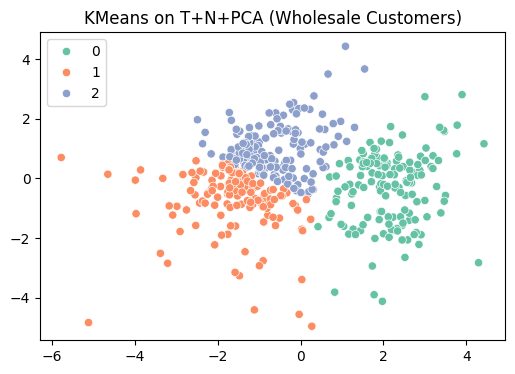

In [10]:
# 1. Load UCI dataset
from ucimlrepo import fetch_ucirepo
wholesale = fetch_ucirepo(name="Wholesale customers")
X = wholesale.data.features

# 2. Use your preprocessing and clustering as before
pca_pipe = preprocessing_methods['T+N+PCA']
X_pca = pca_pipe.fit_transform(X)
labels = apply_clustering(X_pca, 'kmeans', n_clusters=3)

# 3. Plot clusters
def plot_clusters(X_transformed, labels, title):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette='Set2')
    plt.title(title)
    plt.show()

plot_clusters(X_pca, labels, "KMeans on T+N+PCA (Wholesale Customers)")
